In [4]:
import torch
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
csv_path = 'train_img_list.csv'
img_path = './train_data'
to_tensor = transforms.ToTensor()
data_info = pd.read_csv(csv_path, header=None)
image_arr = np.asarray(data_info.iloc[:, 0])
label_arr = np.asarray(data_info.iloc[:, 1])


In [ ]:
index = 500
single_image_name = image_arr[index]
img_as_img = Image.open(img_path + '/' + single_image_name)
img_as_tensor = to_tensor(img_as_img)
single_image_label = label_arr[index]
print(single_image_label)
plt.imshow(img_as_tensor.permute(1, 2, 0))

In [ ]:
img_as_tensor.size()

In [ ]:
import torch.nn as nn
?nn.ReLU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
from torchvision import datasets, transforms
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,)),])
trainset = datasets.MNIST('./data', download=True, train=True, transform=transform)

In [ ]:
trainset = datasets.MNIST('./data', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True)
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape, labels.shape)

In [ ]:
from custom_dataset import CustomDatasetFromImages
traindata = CustomDatasetFromImages('train_img_list.csv','train_data')
for images, labels in traindata:
    print(labels.numpy()[0])
    break


Epoch : 1/1,  Loss: 0.0514

Training Time (in minutes) = 1.6937204798062642
Predicted Digit = 1


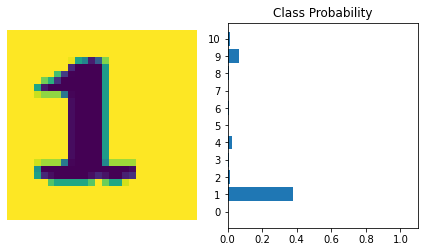

Number Of Images Tested = 12095

Model Accuracy = 0.7197188921041753


In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data.dataset import Dataset
from time import time
import matplotlib.pyplot as plt
import numpy as np

from custom_dataset import CustomDatasetFromImages
from cnn_model import CNNModel


def classify(img, ps):
    ''' 
    Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()/100

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(11), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(11))
    ax2.set_yticklabels(np.arange(11))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,)),])
    traindata = CustomDatasetFromImages('train_img_list.csv', './train_data')
    testdata = CustomDatasetFromImages('test_img_list.csv', './test_data')
    
    # trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True)

    model = CNNModel()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

    num_epochs = 1
    time0 = time()
    for epoch in range(num_epochs):
        running_loss  = 0
        for i, (images, labels) in enumerate(traindata):
            images = Variable(images)
            images = images.unsqueeze(1)
            labels = Variable(labels)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss  += loss.item()
            # if (i+1) % 1000 == 0:
                # print ('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f' %(epoch+1, num_epochs, i+1, traindata.__len__(), loss.item()))
        print ('Epoch : %d/%d,  Loss: %.4f' %(epoch+1, num_epochs, running_loss/traindata.__len__()))
    print("\nTraining Time (in minutes) =",(time()-time0)/60)


    images, labels = next(iter(testdata))
    # replace trainloader to check training accuracy.

    img = images.unsqueeze(1)
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logpb = model(img)

    # Output of the network are log-probabilities, need to take exponential for probabilities
    pb = torch.exp(logpb)
    probab = list(pb.numpy()[0])
    print("Predicted Digit =", probab.index(max(probab)))
    classify(img.view(1, 28, 28), pb)

    # Evaluate model accuracy based on testdata
    correct_count, all_count = 0, 0
    for i, (images,labels) in enumerate(testdata):
        img = images.unsqueeze(1)

        with torch.no_grad():
            logps = model(img)

        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.numpy()[0]
        if(true_label == pred_label): correct_count += 1
        all_count += 1

    print("Number Of Images Tested =", all_count)
    print("\nModel Accuracy =", (correct_count/all_count))



99.98208974419089
Predicted Digit = 10


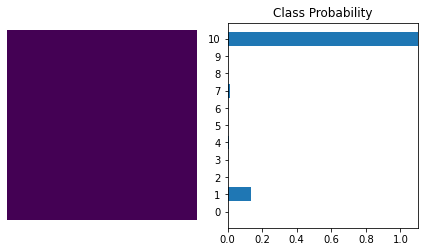

In [7]:
def classify(img, ps):
    ''' 
    Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()/100
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(11), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(11))
    ax2.set_yticklabels(np.arange(11))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()
    plt.show()

def confidence(ps):
    return max(ps)/sum(ps)*100

model = torch.load('digit_recog_cnn.pt')
to_tensor = transforms.ToTensor()
# test_img = Image.open('./test_data/test_7.png')
test_img = Image.open('white0.png')
test_img = to_tensor(test_img)
test_img = test_img.unsqueeze(1)
with torch.no_grad():
        logpb = model(test_img)
pb = torch.exp(logpb)
probab = list(pb.numpy()[0])
print(confidence(probab))
print("Predicted Digit =", probab.index(max(probab)))
classify(test_img.view(1, 28, 28), pb)